<a href="https://colab.research.google.com/github/openjamoses/Model-conversion/blob/main/Torch_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip uninstall tensorflow
!pip uninstall onnx

Uninstalling tensorflow-2.5.0:
  Would remove:
    /usr/local/bin/estimator_ckpt_converter
    /usr/local/bin/import_pb_to_tensorboard
    /usr/local/bin/saved_model_cli
    /usr/local/bin/tensorboard
    /usr/local/bin/tf_upgrade_v2
    /usr/local/bin/tflite_convert
    /usr/local/bin/toco
    /usr/local/bin/toco_from_protos
    /usr/local/lib/python3.7/dist-packages/tensorflow-2.5.0.dist-info/*
    /usr/local/lib/python3.7/dist-packages/tensorflow/*
Proceed (y/n)? y
  Successfully uninstalled tensorflow-2.5.0


In [ ]:
!pip install tensorflow
!pip install onnx==1.8.1
!pip install onnx_tf
#%tensorflow_version 1.x
from tensorflow import keras
import tensorflow as tf
print(tf.__version__)

In [9]:
#Import needed packages
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from onnx_tf.backend import prepare

In [10]:
from google.colab import drive
drive.mount('/content/drive')
path_output = "/content/drive/MyDrive/Colab Notebooks/models/torch/save/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(4*4*50, 500)
        self.fc2 = nn.Linear(500, 10)
 
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*50)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [12]:
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

In [13]:
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
 
    test_loss /= len(test_loader.dataset)
 
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [14]:
#def main():
device =  "cpu"
train_loader = torch.utils.data.DataLoader(
datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(
datasets.MNIST('../data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
batch_size=1000, shuffle=True)
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)
 
for epoch in range(0, 10): 
  train(model, device, train_loader, optimizer, epoch) 
  test(model, device, test_loader)
torch.save(model.state_dict(),path_output+"model.pt")

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode

Train Epoch: 0 [0/60000 (0%)]	Loss: 2.285402
Train Epoch: 0 [6400/60000 (11%)]	Loss: 0.533182
Train Epoch: 0 [12800/60000 (21%)]	Loss: 0.289310
Train Epoch: 0 [19200/60000 (32%)]	Loss: 0.160107
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.239915
Train Epoch: 0 [32000/60000 (53%)]	Loss: 0.118299
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.104063
Train Epoch: 0 [44800/60000 (75%)]	Loss: 0.131760
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.050274
Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.051666

Test set: Average loss: 0.0864, Accuracy: 9752/10000 (98%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.069900
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.205227
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.030660
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.138718
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.027412
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.043145
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.190557
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.020666
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.039339
T

In [ ]:
!pip install pytorch2keras
#!pip install onnx==1.8.1

In [16]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode

In [10]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving hymenoptera_data.zip to hymenoptera_data.zip
User uploaded file "hymenoptera_data.zip" with length 47286322 bytes


In [ ]:
!unzip '/content/hymenoptera_data.zip' -d '/content'

In [17]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '/content/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


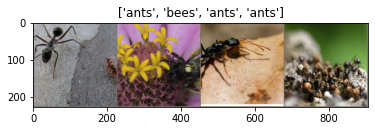

In [18]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [19]:
import csv
import pandas as pd
from datetime import datetime


In [20]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    date = datetime.today().strftime('%Y-%m-%d-%H:%M:%S')

    data_file = open('/content/experiment_train_{}.csv'.format(date), mode='w+', newline='', encoding='utf-8')
    data_writer = csv.writer(data_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    data_writer.writerow(['Model','type', 'Dataset', 'Epoch', 'criterion', 'optimizer', 'scheduler','Train_loss', 'Train_acc', "val_loss", "Val_acc", 'time','Elapse_time','date'])


    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        since_1 = time.time()

        # Each epoch has a training and validation phase
        #data_writer.writerow(['Model','type', 'Dataset', 'Train_loss', 'Train_acc', "val_loss", "Val_acc"])
        rows = [model, 'pytorch','hymenoptera_data','{}/{}'.format(epoch, num_epochs - 1) ,criterion, optimizer, scheduler]
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            rows.append(phase)
            rows.append('Loss: {:.4f}'.format(epoch_loss))
            rows.append('Acc: {:.4f}'.format(epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        time_elapsed_1 = time.time() - since_1
        print()
        rows.append(time.time())
        rows.append('{:.0f}m {:.0f}s'.format(time_elapsed_1 // 60, time_elapsed_1 % 60))
        data_writer.writerow(rows)

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    data_writer.writerow(['','', '', '', '', '', "", 'Best val Acc: {:4f}'.format(best_acc), time.time(),'Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60),''])

    data_file.close()
    return model

In [21]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [22]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [23]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.5784 Acc: 0.7008
val Loss: 0.1967 Acc: 0.9346

Epoch 1/24
----------
train Loss: 0.4701 Acc: 0.7992
val Loss: 0.2721 Acc: 0.9020

Epoch 2/24
----------
train Loss: 0.4989 Acc: 0.8402
val Loss: 0.7209 Acc: 0.7712

Epoch 3/24
----------
train Loss: 0.5800 Acc: 0.7746
val Loss: 0.3048 Acc: 0.8889

Epoch 4/24
----------
train Loss: 0.5187 Acc: 0.8115
val Loss: 0.4605 Acc: 0.8497

Epoch 5/24
----------
train Loss: 0.4788 Acc: 0.8279
val Loss: 0.3519 Acc: 0.8693

Epoch 6/24
----------
train Loss: 0.4766 Acc: 0.7992
val Loss: 0.7293 Acc: 0.8039

Epoch 7/24
----------
train Loss: 0.2228 Acc: 0.9139
val Loss: 0.3651 Acc: 0.8824

Epoch 8/24
----------
train Loss: 0.3892 Acc: 0.8648
val Loss: 0.3200 Acc: 0.9085

Epoch 9/24
----------
train Loss: 0.3849 Acc: 0.8484
val Loss: 0.3004 Acc: 0.8954

Epoch 10/24
----------
train Loss: 0.3505 Acc: 0.8730
val Loss: 0.2603 Acc: 0.9150

Epoch 11/24
----------
train Loss: 0.4322 Acc: 0.8074
val Loss: 0.2920 Acc: 0.8954

Epoch 12/24
----------
t

In [24]:
i_0 = 0
for i, (inputs, labels) in enumerate(dataloaders['train']):
  inputs = inputs.to(device)
  labels = labels.to(device)
  if i_0 == 0:
    torch_images_train = inputs
    torch_labels_train = labels
  else:
    torch_images_train = torch.cat([torch_images_train, inputs], 0)
    torch_labels_train = torch.cat([torch_labels_train, labels], 0)
  i_0 += 1
print(torch_images_train.size(), torch_labels_train.size())

i_0 = 0
for i, (inputs, labels) in enumerate(dataloaders['val']):
  inputs = inputs.to(device)
  labels = labels.to(device)
  if i_0 == 0:
    torch_images_val = inputs
    torch_labels_val = labels
  else:
    torch_images_val = torch.cat([torch_images_val, inputs], 0)
    torch_labels_val = torch.cat([torch_labels_val, labels], 0)
  i_0 += 1
print(torch_images_val.size(), torch_labels_val.size())

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


torch.Size([244, 3, 224, 224]) torch.Size([244])
torch.Size([153, 3, 224, 224]) torch.Size([153])


In [25]:
pred_torch_fit_train = model_ft(torch_images_train)
pred_torch_fit_val = model_ft(torch_images_val)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


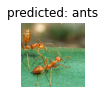

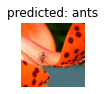

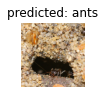

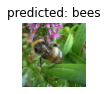

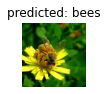

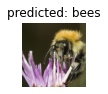

In [26]:
visualize_model(model_ft)

In [27]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [28]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=10)

Epoch 0/9
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.5682 Acc: 0.6844
val Loss: 0.1923 Acc: 0.9281

Epoch 1/9
----------
train Loss: 0.5015 Acc: 0.7910
val Loss: 0.1870 Acc: 0.9216

Epoch 2/9
----------
train Loss: 0.4524 Acc: 0.7910
val Loss: 0.1825 Acc: 0.9346

Epoch 3/9
----------
train Loss: 0.5152 Acc: 0.7746
val Loss: 0.1563 Acc: 0.9608

Epoch 4/9
----------
train Loss: 0.4237 Acc: 0.8361
val Loss: 0.1698 Acc: 0.9608

Epoch 5/9
----------
train Loss: 0.5246 Acc: 0.8156
val Loss: 0.2186 Acc: 0.9216

Epoch 6/9
----------
train Loss: 0.5210 Acc: 0.7541
val Loss: 0.3892 Acc: 0.8301

Epoch 7/9
----------
train Loss: 0.5575 Acc: 0.8074
val Loss: 0.2870 Acc: 0.8889

Epoch 8/9
----------
train Loss: 0.3131 Acc: 0.8566
val Loss: 0.1691 Acc: 0.9542

Epoch 9/9
----------
train Loss: 0.3490 Acc: 0.8525
val Loss: 0.1765 Acc: 0.9346

Training complete in 4m 46s
Best val Acc: 0.960784


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


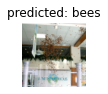

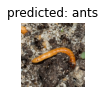

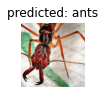

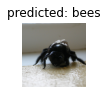

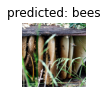

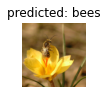

In [29]:
visualize_model(model_conv)
plt.ioff()
plt.show()

In [ ]:
!pip install pytorch2keras

In [ ]:
model_conv

In [31]:
import numpy as np
import torch
from torch.autograd import Variable
from pytorch2keras.converter import pytorch_to_keras
import torchvision.models as models

In [32]:
input_np = np.random.uniform(0, 1, (1, 3, 180, 180))
input_var = Variable(torch.FloatTensor(input_np))

In [33]:
k_model_model_conv = pytorch_to_keras(model_conv, input_var, [(3, 180, 180,)], verbose=True, change_ordering=True)

INFO:pytorch2keras:Converter is called.
DEBUG:pytorch2keras:Input_names:
DEBUG:pytorch2keras:['input_0']
DEBUG:pytorch2keras:Output_names:
DEBUG:pytorch2keras:['output_0']
INFO:onnx2keras:Converter is called.
DEBUG:onnx2keras:List input shapes:
DEBUG:onnx2keras:[(3, 180, 180)]
DEBUG:onnx2keras:List inputs:
DEBUG:onnx2keras:Input 0 -> input_0.
DEBUG:onnx2keras:List outputs:
DEBUG:onnx2keras:Output 0 -> output_0.
DEBUG:onnx2keras:Gathering weights to dictionary.
DEBUG:onnx2keras:Found weight fc.weight with shape (2, 512).
DEBUG:onnx2keras:Found weight fc.bias with shape (2,).
DEBUG:onnx2keras:Found weight 193 with shape (64, 3, 7, 7).
DEBUG:onnx2keras:Found weight 194 with shape (64,).
DEBUG:onnx2keras:Found weight 196 with shape (64, 64, 3, 3).
DEBUG:onnx2keras:Found weight 197 with shape (64,).
DEBUG:onnx2keras:Found weight 199 with shape (64, 64, 3, 3).
DEBUG:onnx2keras:Found weight 200 with shape (64,).
DEBUG:onnx2keras:Found weight 202 with shape (64, 64, 3, 3).
DEBUG:onnx2keras:Fou

graph(%input_0 : Float(1, 3, 180, 180, strides=[97200, 32400, 180, 1], requires_grad=0, device=cpu),
      %fc.weight : Float(2, 512, strides=[512, 1], requires_grad=1, device=cpu),
      %fc.bias : Float(2, strides=[1], requires_grad=1, device=cpu),
      %193 : Float(64, 3, 7, 7, strides=[147, 49, 7, 1], requires_grad=0, device=cpu),
      %194 : Float(64, strides=[1], requires_grad=0, device=cpu),
      %196 : Float(64, 64, 3, 3, strides=[576, 9, 3, 1], requires_grad=0, device=cpu),
      %197 : Float(64, strides=[1], requires_grad=0, device=cpu),
      %199 : Float(64, 64, 3, 3, strides=[576, 9, 3, 1], requires_grad=0, device=cpu),
      %200 : Float(64, strides=[1], requires_grad=0, device=cpu),
      %202 : Float(64, 64, 3, 3, strides=[576, 9, 3, 1], requires_grad=0, device=cpu),
      %203 : Float(64, strides=[1], requires_grad=0, device=cpu),
      %205 : Float(64, 64, 3, 3, strides=[576, 9, 3, 1], requires_grad=0, device=cpu),
      %206 : Float(64, strides=[1], requires_grad=

DEBUG:onnx2keras:Found weight 233 with shape (256,).
DEBUG:onnx2keras:Found weight 235 with shape (256, 256, 3, 3).
DEBUG:onnx2keras:Found weight 236 with shape (256,).
DEBUG:onnx2keras:Found weight 238 with shape (512, 256, 3, 3).
DEBUG:onnx2keras:Found weight 239 with shape (512,).
DEBUG:onnx2keras:Found weight 241 with shape (512, 512, 3, 3).
DEBUG:onnx2keras:Found weight 242 with shape (512,).
DEBUG:onnx2keras:Found weight 244 with shape (512, 256, 1, 1).
DEBUG:onnx2keras:Found weight 245 with shape (512,).
DEBUG:onnx2keras:Found weight 247 with shape (512, 512, 3, 3).
DEBUG:onnx2keras:Found weight 248 with shape (512,).
DEBUG:onnx2keras:Found weight 250 with shape (512, 512, 3, 3).
DEBUG:onnx2keras:Found weight 251 with shape (512,).
DEBUG:onnx2keras:Found input input_0 with shape (3, 180, 180)
DEBUG:onnx2keras:######
DEBUG:onnx2keras:...
DEBUG:onnx2keras:Converting ONNX operation
DEBUG:onnx2keras:type: Conv
DEBUG:onnx2keras:node_name: 192
DEBUG:onnx2keras:node_params: {'dilations

In [34]:
batch_size = 32
img_height = 180
img_width = 180
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir+'/train',
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir+'/val',
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 245 files belonging to 2 classes.
Using 196 files for training.
Found 153 files belonging to 2 classes.
Using 30 files for validation.


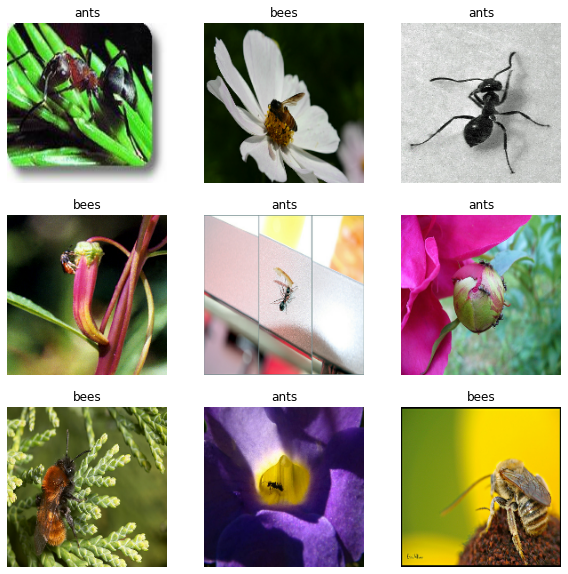

In [35]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [36]:
i = 0
for image, label in train_ds:
  #print(image_batch.shape)
  #print(labels_batch.shape)
  if i == 0:
    images = image
    labels = label
  else:
    images = tf.concat([images,image], 0)
    labels = tf.concat([labels,label], 0)
  i += 1
labels2 = tf.reshape(labels, [-1,1])
print(images.shape, labels2.shape)

(196, 180, 180, 3) (196, 1)


In [32]:
# Save model to SavedModel format
tf.saved_model.save(k_model_model_conv, "content/k_model_model_conv")

# Convert Keras model to ConcreteFunction
full_model = tf.function(lambda x: k_model_model_conv(x))
full_model = full_model.get_concrete_function(
    tf.TensorSpec(k_model_model_conv.inputs[0].shape, k_model_model_conv.inputs[0].dtype))


FOR DEVS: If you are overwriting _tracking_metadata in your class, this property has been used to save metadata in the SavedModel. The metadta field will be deprecated soon, so please move the metadata to a different file.


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)

FOR DEVS: If you are overwriting _tracking_metadata in your class, this property has been used to save metadata in the SavedModel. The metadta field will be deprecated soon, so please move the metadata to a different file.


INFO:tensorflow:Assets written to: content/k_model_model_conv/assets


INFO:tensorflow:Assets written to: content/k_model_model_conv/assets


In [33]:
from tensorflow.python.framework.convert_to_constants import convert_variables_to_constants_v2
# Get frozen ConcreteFunction
frozen_func = convert_variables_to_constants_v2(full_model)
frozen_func.graph.as_graph_def()

In [1]:
print("-" * 50)
print("Frozen model layers: ")
for layer in [op.name for op in frozen_func.graph.get_operations()]:
    print(layer)

print("-" * 50)
print("Frozen model inputs: ")
print(frozen_func.inputs)
print("Frozen model outputs: ")
print(frozen_func.outputs)

# Save frozen graph from frozen ConcreteFunction to hard drive
tf.io.write_graph(graph_or_graph_def=frozen_func.graph,
                  logdir="content/k_model_model_conv_frozen_graph",
                  name="frozen_graph.pb",
                  as_text=False)

--------------------------------------------------
Frozen model layers: 


NameError: ignored

In [45]:
#model_reload_frozen_graph = tf.keras.models.load_model('/content/content/k_model_model_conv_frozen_graph') #same file path
# Re-evaluate the model
#loss, acc = model_reload.evaluate(test_images, test_labels, verbose=2)
#print("Restored model, accuracy: {:5.2f}%".format(100 * acc))

In [43]:
#k_model_model_conv.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

In [ ]:
#k_model_model_conv
#.fit(images, labels, epochs=10)

In [37]:
k_model_model_conv.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [38]:
fit_history_k_model_model_conv = k_model_model_conv.fit(
  train_ds,
  validation_data=val_ds,
  epochs=15
)

Epoch 1/15
7/7 [==============================] - 30s 4s/step - loss: 104.0201 - accuracy: 0.4745 - val_loss: 3.7830 - val_accuracy: 0.6333
Epoch 2/15
7/7 [==============================] - 27s 4s/step - loss: 7.8975 - accuracy: 0.5051 - val_loss: 0.6641 - val_accuracy: 0.6000
Epoch 3/15
7/7 [==============================] - 27s 4s/step - loss: 0.7720 - accuracy: 0.4694 - val_loss: 0.6578 - val_accuracy: 0.6333
Epoch 4/15
7/7 [==============================] - 27s 4s/step - loss: 0.7749 - accuracy: 0.5051 - val_loss: 0.6687 - val_accuracy: 0.6333
Epoch 5/15
7/7 [==============================] - 33s 5s/step - loss: 0.6962 - accuracy: 0.5051 - val_loss: 0.6764 - val_accuracy: 0.7000
Epoch 6/15
7/7 [==============================] - 29s 4s/step - loss: 0.6780 - accuracy: 0.5867 - val_loss: 0.8859 - val_accuracy: 0.4000
Epoch 7/15
7/7 [==============================] - 28s 4s/step - loss: 0.7165 - accuracy: 0.5000 - val_loss: 0.6572 - val_accuracy: 0.6333
Epoch 8/15
7/7 [================

In [39]:
# Evaluate the model
loss, acc = k_model_model_conv.evaluate(images, labels, verbose=2)
print("training dataset model, accuracy: {:5.2f}%".format(100 * acc))

7/7 - 7s - loss: 0.6650 - accuracy: 0.5867
training dataset model, accuracy: 58.67%


In [40]:
i = 0
for image, label in val_ds:
  #print(image_batch.shape)
  #print(labels_batch.shape)
  if i == 0:
    images_val = image
    labels_val = label
  else:
    images_val = tf.concat([images_val,image], 0)
    labels_val = tf.concat([labels_val,label], 0)
  i += 1
#labels2 = tf.reshape(labels_val, [-1,1])
print(images_val.shape, labels_val.shape)

(30, 180, 180, 3) (30,)


In [68]:
def export_history_csv(history_):
  since = time.time()
  date = datetime.today().strftime('%Y-%m-%d-%H:%M:%S')
  data_file = open('/content/tensorflow_exp_train_{}.csv'.format(date), mode='w+', newline='', encoding='utf-8')
  data_writer = csv.writer(data_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
  data_writer.writerow(['Model','type', 'Dataset', 'Epoch', 'criterion', 'optimizer', 'scheduler','Train_loss', 'Train_acc', "val_loss", "Val_acc", 'time','Elapse_time','date'])
  for epoch_ in history_.epoch:
    data_writer.writerow([history_.model,'tensorflow', 'hymenoptera', epoch_, '', 
                          history_.model.optimizer, '',history_.history['loss'][epoch_], history_.history['accuracy'][epoch_], 
                          history_.history['val_loss'][epoch_], history_.history['val_accuracy'][epoch_], '','',date])
  data_file.close()
  

In [69]:
export_history_csv(fit_history_k_model_model_conv)

In [41]:
# Evaluate the model
loss, acc = k_model_model_conv.evaluate(images_val, labels_val, verbose=2)
print("validation dataset model, accuracy: {:5.2f}%".format(100 * acc))

1/1 - 1s - loss: 0.6782 - accuracy: 0.6000
validation dataset model, accuracy: 60.00%


In [70]:
k_model_model_ft = pytorch_to_keras(model_ft, input_var, [(3, 180, 180,)], verbose=True, change_ordering=True)

INFO:pytorch2keras:Converter is called.
DEBUG:pytorch2keras:Input_names:
DEBUG:pytorch2keras:['input_0']
DEBUG:pytorch2keras:Output_names:
DEBUG:pytorch2keras:['output_0']
INFO:onnx2keras:Converter is called.
DEBUG:onnx2keras:List input shapes:
DEBUG:onnx2keras:[(3, 180, 180)]
DEBUG:onnx2keras:List inputs:
DEBUG:onnx2keras:Input 0 -> input_0.
DEBUG:onnx2keras:List outputs:
DEBUG:onnx2keras:Output 0 -> output_0.
DEBUG:onnx2keras:Gathering weights to dictionary.
DEBUG:onnx2keras:Found weight fc.weight with shape (2, 512).
DEBUG:onnx2keras:Found weight fc.bias with shape (2,).
DEBUG:onnx2keras:Found weight 193 with shape (64, 3, 7, 7).
DEBUG:onnx2keras:Found weight 194 with shape (64,).
DEBUG:onnx2keras:Found weight 196 with shape (64, 64, 3, 3).
DEBUG:onnx2keras:Found weight 197 with shape (64,).
DEBUG:onnx2keras:Found weight 199 with shape (64, 64, 3, 3).
DEBUG:onnx2keras:Found weight 200 with shape (64,).
DEBUG:onnx2keras:Found weight 202 with shape (64, 64, 3, 3).
DEBUG:onnx2keras:Fou

graph(%input_0 : Float(1, 3, 180, 180, strides=[97200, 32400, 180, 1], requires_grad=0, device=cpu),
      %fc.weight : Float(2, 512, strides=[512, 1], requires_grad=1, device=cpu),
      %fc.bias : Float(2, strides=[1], requires_grad=1, device=cpu),
      %193 : Float(64, 3, 7, 7, strides=[147, 49, 7, 1], requires_grad=0, device=cpu),
      %194 : Float(64, strides=[1], requires_grad=0, device=cpu),
      %196 : Float(64, 64, 3, 3, strides=[576, 9, 3, 1], requires_grad=0, device=cpu),
      %197 : Float(64, strides=[1], requires_grad=0, device=cpu),
      %199 : Float(64, 64, 3, 3, strides=[576, 9, 3, 1], requires_grad=0, device=cpu),
      %200 : Float(64, strides=[1], requires_grad=0, device=cpu),
      %202 : Float(64, 64, 3, 3, strides=[576, 9, 3, 1], requires_grad=0, device=cpu),
      %203 : Float(64, strides=[1], requires_grad=0, device=cpu),
      %205 : Float(64, 64, 3, 3, strides=[576, 9, 3, 1], requires_grad=0, device=cpu),
      %206 : Float(64, strides=[1], requires_grad=

DEBUG:onnx2keras:... found all, continue
DEBUG:onnx2keras:conv:Conv with bias
DEBUG:onnx2keras:conv:2D convolution
DEBUG:onnx2keras:conv:Paddings exist, add ZeroPadding layer
DEBUG:onnx2keras:Output TF Layer -> KerasTensor(type_spec=TensorSpec(shape=(None, 64, 90, 90), dtype=tf.float32, name=None), name='192/BiasAdd:0', description="created by layer '192'")
DEBUG:onnx2keras:######
DEBUG:onnx2keras:...
DEBUG:onnx2keras:Converting ONNX operation
DEBUG:onnx2keras:type: Relu
DEBUG:onnx2keras:node_name: 125
DEBUG:onnx2keras:node_params: {'change_ordering': True, 'name_policy': None}
DEBUG:onnx2keras:...
DEBUG:onnx2keras:Check if all inputs are available:
DEBUG:onnx2keras:Check input 0 (name 192).
DEBUG:onnx2keras:... found all, continue
DEBUG:onnx2keras:Output TF Layer -> KerasTensor(type_spec=TensorSpec(shape=(None, 64, 90, 90), dtype=tf.float32, name=None), name='125/Relu:0', description="created by layer '125'")
DEBUG:onnx2keras:######
DEBUG:onnx2keras:...
DEBUG:onnx2keras:Converting ONN

In [91]:
#criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
##optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
#exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)
#model.compile(optimizer="adam", loss="mse", metrics=["mae"])

opt = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)

In [94]:
#k_model_model_ft.compile(
#  optimizer='SGD',
#  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
#  metrics=['accuracy'])

k_model_model_ft.compile(
  optimizer=opt,
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [95]:
since = time.time()
fit_history_k_model_model_ft = k_model_model_ft.fit(
  train_ds,
  validation_data=val_ds,
  epochs=5
)
time_elapsed = time.time() - since
print('Training complete in {:.0f}m {:.0f}s'.format(
time_elapsed // 60, time_elapsed % 60))

Epoch 1/5
7/7 [==============================] - 29s 4s/step - loss: nan - accuracy: 0.4949 - val_loss: nan - val_accuracy: 0.3667
Epoch 2/5
7/7 [==============================] - 28s 4s/step - loss: nan - accuracy: 0.4949 - val_loss: nan - val_accuracy: 0.3667
Epoch 3/5
7/7 [==============================] - 28s 4s/step - loss: nan - accuracy: 0.4949 - val_loss: nan - val_accuracy: 0.3667
Epoch 4/5
7/7 [==============================] - 28s 4s/step - loss: nan - accuracy: 0.4949 - val_loss: nan - val_accuracy: 0.3667
Epoch 5/5
7/7 [==============================] - 28s 4s/step - loss: nan - accuracy: 0.4949 - val_loss: nan - val_accuracy: 0.3667
Training complete in 2m 33s


In [73]:
export_history_csv(fit_history_k_model_model_ft)

In [84]:
# Include the epoch in the file name (uses `str.format`)
checkpoint_path = "/content/content/training_1/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

batch_size = 32

# Create a callback that saves the model's weights every 5 epochs
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1, 
    save_weights_only=True,
    save_freq=5*batch_size)

In [85]:
# Save the weights using the `checkpoint_path` format
k_model_model_ft.save_weights(checkpoint_path.format(epoch=0))

# Train the model with the new callback
k_model_model_ft.fit(images, 
          labels,
          epochs=20, 
          batch_size=batch_size, 
          callbacks=[cp_callback],
          validation_data=(images_val, labels_val),
          verbose=0)

In [86]:
latest = tf.train.latest_checkpoint(checkpoint_dir)
latest

'/content/content/training_1/cp-0000.ckpt'

In [87]:
# Create a new model instance
#k_model_model_ft2 = create_model()

# Load the previously saved weights
k_model_model_ft.load_weights(latest)

# Re-evaluate the model
loss, acc = k_model_model_ft.evaluate(images, labels, verbose=2)
print("Restored model, accuracy: {:5.2f}%".format(100 * acc))

7/7 - 9s - loss: 0.6271 - accuracy: 0.6429
Restored model, accuracy: 64.29%


In [90]:
model_ft

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [88]:
# Re-evaluate the model
loss, acc = model_ft.evaluate(images, labels, verbose=2)
print("Restored model, accuracy: {:5.2f}%".format(100 * acc))

AttributeError: ignored

In [ ]:
# Train the models up using fashion_mnist dataset

In [96]:
transform2 = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset2 = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform2)
trainloader2 = torch.utils.data.DataLoader(trainset2, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset2 = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform2)
testloader2 = torch.utils.data.DataLoader(testset2, batch_size=batch_size,
                                         shuffle=False, num_workers=2)


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
#model_ft = model_ft.to(device)

#criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
#optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
t1 = 0
for i, data in enumerate(trainloader2, 0):
    inputs, labels = data
    #print(len(inputs), len(labels))

In [108]:
def train_pytorch(model, criterion, optimizer, scheduler, trainloader, num_epochs=25):
  since = time.time()
  date = datetime.today().strftime('%Y-%m-%d-%H:%M:%S')

  data_file = open('/content/experiment_train_{}.csv'.format(date), mode='w+', newline='', encoding='utf-8')
  data_writer = csv.writer(data_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
  data_writer.writerow(['Model','type', 'Dataset', 'Epoch', 'criterion', 'optimizer', 'scheduler',"loss", "acc", 'time','Elapse_time','date'])
  total_size = 0
  for i, data in enumerate(trainloader, 0):
    inputs, labels = data
    total_size += len(inputs)
  best_model_wts = copy.deepcopy(model.state_dict())
  best_acc = 0.0
  model.train()  # Set model to training mode
  best_model_wts = copy.deepcopy(model.state_dict())
  best_acc = 0.0
  for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch, num_epochs - 1))
    print('-' * 10)
    since_1 = time.time()
    rows = [model, 'pytorch','CIFAR10_train','{}/{}'.format(epoch, num_epochs - 1) ,criterion, optimizer, scheduler]
    print('Epoch {}/{}'.format(epoch, num_epochs - 1))
    print('-' * 10)
    since_1 = time.time()
    for i, data in enumerate(trainloader, 0): 
      # get the inputs; data is a list of [inputs, labels] 
      inputs, labels = data
      inputs = inputs.to(device)
      labels = labels.to(device)
      # zero the parameter gradients
      optimizer.zero_grad()
      # forward
      # track history if only in train
      outputs = model(inputs)
      _, preds = torch.max(outputs, 1)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()
      # statistics
      running_loss += loss.item() * inputs.size(0)
      running_corrects += torch.sum(preds == labels.data)
    time_elapsed_1 = time.time() - since_1
    print()
    epoch_loss = running_loss / total_size
    epoch_acc = running_corrects.double() / total_size
    print('val Loss: {:.4f} Acc: {:.4f}'.format(
                epoch_loss, epoch_acc))
    rows.append(phase)
    rows.append('{:.4f}'.format(epoch_loss))
    rows.append('{:.4f}'.format(epoch_acc))

    rows.append(time.time())
    rows.append('{:.0f}m {:.0f}s'.format(time_elapsed_1 // 60, time_elapsed_1 % 60))
    data_writer.writerow(rows)
  time_elapsed = time.time() - since
  print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
  print('Best val Acc: {:4f}'.format(best_acc))

  # load best model weights
  model.load_state_dict(best_model_wts)
  data_writer.writerow(['','', '', '', '', '', "", 'Best val Acc: {:4f}'.format(best_acc), time.time(),'Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60),''])

  data_file.close()
  return model

def test_pytorch(model, criterion, optimizer, scheduler, testloader, num_epochs=25):
  since = time.time()
  date = datetime.today().strftime('%Y-%m-%d-%H:%M:%S')

  data_file = open('/content/experiment_val_{}.csv'.format(date), mode='w+', newline='', encoding='utf-8')
  data_writer = csv.writer(data_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
  data_writer.writerow(['Model','type', 'Dataset', 'Epoch', 'criterion', 'optimizer', 'scheduler', "loss", "acc", 'time','Elapse_time','date'])
  total_size = 0
  for i, data in enumerate(testloader, 0):
    inputs, labels = data
    total_size += len(inputs)

  best_model_wts = copy.deepcopy(model.state_dict())
  best_acc = 0.0
  model.eval()   # Set model to evaluate mode
  best_model_wts = copy.deepcopy(model.state_dict())
  best_acc = 0.0
  for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch, num_epochs - 1))
    print('-' * 10)
    since_1 = time.time()
    rows = [model, 'pytorch','CIFAR10_val','{}/{}'.format(epoch, num_epochs - 1) ,criterion, optimizer, scheduler]
    print('Epoch {}/{}'.format(epoch, num_epochs - 1))
    print('-' * 10)
    since_1 = time.time()
    for i, data in enumerate(testloader, 0): 
      # get the inputs; data is a list of [inputs, labels] 
      inputs, labels = data
      inputs = inputs.to(device)
      labels = labels.to(device)
      # zero the parameter gradients
      optimizer.zero_grad()
      # statistics
      running_loss += loss.item() * inputs.size(0)
      running_corrects += torch.sum(preds == labels.data)
      
    time_elapsed_1 = time.time() - since_1
    
    
    epoch_loss = running_loss / total_size
    epoch_acc = running_corrects.double() / total_size
    if epoch_acc > best_acc:
      best_acc = epoch_acc
      best_model_wts = copy.deepcopy(model.state_dict())
    print('val Loss: {:.4f} Acc: {:.4f}'.format(
                epoch_loss, epoch_acc))
    rows.append(phase)
    rows.append('{:.4f}'.format(epoch_loss))
    rows.append('{:.4f}'.format(epoch_acc))

    rows.append(time.time())
    rows.append('{:.0f}m {:.0f}s'.format(time_elapsed_1 // 60, time_elapsed_1 % 60))
    data_writer.writerow(rows)

  time_elapsed = time.time() - since
  print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
  print('Best val Acc: {:4f}'.format(best_acc))

  # load best model weights
  model.load_state_dict(best_model_wts)
  data_writer.writerow(['','', '', '', '', 'Best val Acc: {:4f}'.format(best_acc), time.time(),'Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60),''])

  data_file.close()
  return model

In [76]:
train_images = train_images / 255.0

test_images = test_images / 255.0

In [77]:
k_model_model_ft.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [84]:
k_model_model_ft.output.

<KerasTensor: shape=(None, 2) dtype=float32 (created by layer 'output_0')>

In [110]:
model_ft2 = train_pytorch(model_ft, criterion, optimizer_ft, exp_lr_scheduler, trainloader2, num_epochs=5)

Epoch 0/4
----------
Epoch 0/4
----------


IndexError: ignored

In [87]:
!pip install MobileNetV2

ERROR: Could not find a version that satisfies the requirement MobileNetV2 (from versions: none)
ERROR: No matching distribution found for MobileNetV2


In [86]:
from MobileNetV2 import mobilenet_v2

ModuleNotFoundError: ignored

In [ ]:
def train_model_pytorch2(model, criterion, optimizer, scheduler, num_epochs=25, train_images, train_labels, val_images, val_labels):
    since = time.time()
    date = datetime.today().strftime('%Y-%m-%d-%H:%M:%S')

    data_file = open('/content/torch_exp_train_{}.csv'.format(date), mode='w+', newline='', encoding='utf-8')
    data_writer = csv.writer(data_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    data_writer.writerow(['Model','type', 'Dataset', 'Epoch', 'criterion', 'optimizer', 'scheduler','Train_loss', 'Train_acc', "val_loss", "Val_acc", 'time','Elapse_time','date'])


    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        since_1 = time.time()

        # Each epoch has a training and validation phase
        #data_writer.writerow(['Model','type', 'Dataset', 'Train_loss', 'Train_acc', "val_loss", "Val_acc"])
        rows = [model, 'pytorch','hymenoptera_data','{}/{}'.format(epoch, num_epochs - 1) ,criterion, optimizer, scheduler]
        model.train()  # Set model to training mode
        running_loss = 0.0
        running_corrects = 0
        optimizer.zero_grad()
        with torch.set_grad_enabled(phase == 'train'): 
          outputs = model(inputs) 
          _, preds = torch.max(outputs, 1)
          loss = criterion(outputs, labels)
          loss.backward() 
          optimizer.step()
        # statistics
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        scheduler.step()
        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects.double() / dataset_sizes[phase]

        print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
        rows.append(phase)
        rows.append('Loss: {:.4f}'.format(epoch_loss))
        rows.append('Acc: {:.4f}'.format(epoch_acc))

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()


        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            rows.append(phase)
            rows.append('Loss: {:.4f}'.format(epoch_loss))
            rows.append('Acc: {:.4f}'.format(epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        time_elapsed_1 = time.time() - since_1
        print()
        rows.append(time.time())
        rows.append('{:.0f}m {:.0f}s'.format(time_elapsed_1 // 60, time_elapsed_1 % 60))
        data_writer.writerow(rows)

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    data_writer.writerow(['','', '', '', '', '', "", 'Best val Acc: {:4f}'.format(best_acc), time.time(),'Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60),''])

    data_file.close()
    return model

In [ ]:
input_np = np.random.uniform(0, 1, (1, 3, 224, 224))
input_var = Variable(torch.FloatTensor(input_np))
model_resnet = models.resnet18()
model_resnet.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
k_model = pytorch_to_keras(model_resnet, input_var, [(3, 224, 224,)], verbose=True, change_ordering=True)

INFO:pytorch2keras:Converter is called.
DEBUG:pytorch2keras:Input_names:
DEBUG:pytorch2keras:['input_0']
DEBUG:pytorch2keras:Output_names:
DEBUG:pytorch2keras:['output_0']
INFO:onnx2keras:Converter is called.
DEBUG:onnx2keras:List input shapes:
DEBUG:onnx2keras:[(3, 224, 224)]
DEBUG:onnx2keras:List inputs:
DEBUG:onnx2keras:Input 0 -> input_0.
DEBUG:onnx2keras:List outputs:
DEBUG:onnx2keras:Output 0 -> output_0.
DEBUG:onnx2keras:Gathering weights to dictionary.
DEBUG:onnx2keras:Found weight fc.weight with shape (1000, 512).
DEBUG:onnx2keras:Found weight fc.bias with shape (1000,).
DEBUG:onnx2keras:Found weight 193 with shape (64, 3, 7, 7).
DEBUG:onnx2keras:Found weight 194 with shape (64,).
DEBUG:onnx2keras:Found weight 196 with shape (64, 64, 3, 3).
DEBUG:onnx2keras:Found weight 197 with shape (64,).
DEBUG:onnx2keras:Found weight 199 with shape (64, 64, 3, 3).
DEBUG:onnx2keras:Found weight 200 with shape (64,).
DEBUG:onnx2keras:Found weight 202 with shape (64, 64, 3, 3).
DEBUG:onnx2ker

graph(%input_0 : Float(1, 3, 224, 224, strides=[150528, 50176, 224, 1], requires_grad=0, device=cpu),
      %fc.weight : Float(1000, 512, strides=[512, 1], requires_grad=1, device=cpu),
      %fc.bias : Float(1000, strides=[1], requires_grad=1, device=cpu),
      %193 : Float(64, 3, 7, 7, strides=[147, 49, 7, 1], requires_grad=0, device=cpu),
      %194 : Float(64, strides=[1], requires_grad=0, device=cpu),
      %196 : Float(64, 64, 3, 3, strides=[576, 9, 3, 1], requires_grad=0, device=cpu),
      %197 : Float(64, strides=[1], requires_grad=0, device=cpu),
      %199 : Float(64, 64, 3, 3, strides=[576, 9, 3, 1], requires_grad=0, device=cpu),
      %200 : Float(64, strides=[1], requires_grad=0, device=cpu),
      %202 : Float(64, 64, 3, 3, strides=[576, 9, 3, 1], requires_grad=0, device=cpu),
      %203 : Float(64, strides=[1], requires_grad=0, device=cpu),
      %205 : Float(64, 64, 3, 3, strides=[576, 9, 3, 1], requires_grad=0, device=cpu),
      %206 : Float(64, strides=[1], require

DEBUG:onnx2keras:Found weight 242 with shape (512,).
DEBUG:onnx2keras:Found weight 244 with shape (512, 256, 1, 1).
DEBUG:onnx2keras:Found weight 245 with shape (512,).
DEBUG:onnx2keras:Found weight 247 with shape (512, 512, 3, 3).
DEBUG:onnx2keras:Found weight 248 with shape (512,).
DEBUG:onnx2keras:Found weight 250 with shape (512, 512, 3, 3).
DEBUG:onnx2keras:Found weight 251 with shape (512,).
DEBUG:onnx2keras:Found input input_0 with shape (3, 224, 224)
DEBUG:onnx2keras:######
DEBUG:onnx2keras:...
DEBUG:onnx2keras:Converting ONNX operation
DEBUG:onnx2keras:type: Conv
DEBUG:onnx2keras:node_name: 192
DEBUG:onnx2keras:node_params: {'dilations': [1, 1], 'group': 1, 'kernel_shape': [7, 7], 'pads': [3, 3, 3, 3], 'strides': [2, 2], 'change_ordering': True, 'name_policy': None}
DEBUG:onnx2keras:...
DEBUG:onnx2keras:Check if all inputs are available:
DEBUG:onnx2keras:Check input 0 (name input_0).
DEBUG:onnx2keras:Check input 1 (name 193).
DEBUG:onnx2keras:The input not found in layers / mo

In [ ]:
for i in range(3): 
  input_np = np.random.uniform(0, 1, (1, 3, 224, 224)) 
  input_var = Variable(torch.FloatTensor(input_np)) 
  output = model_resnet(input_var) 
  pytorch_output = output.data.numpy()
  keras_output = k_model.predict(np.transpose(input_np, [0, 2, 3, 1]))
  error = np.max(pytorch_output - keras_output)
  print('error -- ', error)  # Around zero :)

error --  8.34465e-07
error --  9.536743e-07
error --  1.0728836e-06


In [ ]:
from torchvision import models
#dir(models)

In [ ]:
alexnet = models.alexnet(pretrained=True)

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


In [ ]:
print(alexnet)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [ ]:
from torchvision import transforms
transform = transforms.Compose([            #[1]
 transforms.Resize(256),                    #[2]
 transforms.CenterCrop(224),                #[3]
 transforms.ToTensor(),                     #[4]
 transforms.Normalize(                      #[5]
 mean=[0.485, 0.456, 0.406],                #[6]
 std=[0.229, 0.224, 0.225]                  #[7]
 )])

In [ ]:
# Import Pillow
from PIL import Image
path = '/Users/mosesopenja/Documents/summer2021/ICSE-2021/Presentation/Images/'
img = Image.open(path_output+"dog.jpg")


In [ ]:
img_t = transform(img)
batch_t = torch.unsqueeze(img_t, 0)

In [ ]:
alexnet.eval()

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [ ]:
out = alexnet(batch_t)
print(out.shape)

torch.Size([1, 1000])


In [ ]:
# Download classes text file
!wget https://raw.githubusercontent.com/Lasagne/Recipes/master/examples/resnet50/imagenet_classes.txt

--2021-06-26 08:25:06--  https://raw.githubusercontent.com/Lasagne/Recipes/master/examples/resnet50/imagenet_classes.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 21674 (21K) [text/plain]
Saving to: ‘imagenet_classes.txt’

imagenet_classes.tx 100%[===================>]  21.17K  --.-KB/s    in 0.001s  

2021-06-26 08:25:06 (34.3 MB/s) - ‘imagenet_classes.txt’ saved [21674/21674]



In [ ]:
with open('/content/imagenet_classes.txt') as f:
  classes = [line.strip() for line in f.readlines()]

In [ ]:
_, indices = torch.sort(out, descending=True)
percentage = torch.nn.functional.softmax(out, dim=1)[0] * 100
[(classes[idx], percentage[idx].item()) for idx in indices[0][:5]]

[('Labrador retriever', 41.585174560546875),
 ('golden retriever', 16.591665267944336),
 ('Saluki, gazelle hound', 16.286867141723633),
 ('whippet', 2.8539085388183594),
 ('Ibizan hound, Ibizan Podenco', 2.392474889755249)]

In [ ]:
img = Image.open(path_output+"strawberries.jpg")

In [ ]:
def predict(img):
  img_t = transform(img)
  batch_t = torch.unsqueeze(img_t, 0)
  out = alexnet(batch_t)
  print(out.shape)
  with open('/content/imagenet_classes.txt') as f: 
    classes = [line.strip() for line in f.readlines()]
  _, indices = torch.sort(out, descending=True) 
  percentage = torch.nn.functional.softmax(out, dim=1)[0] * 100
  prediction_scores = [(classes[idx], percentage[idx].item()) for idx in indices[0][:5]]
  #print(prediction_scores)
  return prediction_scores

In [ ]:
predict(img)

torch.Size([1, 1000])


[('strawberry', 99.99365997314453),
 ('custard apple', 0.001047822879627347),
 ('banana', 0.000820187502540648),
 ('orange', 0.0007371793035417795),
 ('confectionery, confectionary, candy store', 0.0005758320912718773)]

In [ ]:
# Input to the model
x = torch.randn(3, 3, 224, 224, requires_grad=True)
torch_out = alexnet(x)

# Export the model
torch.onnx.export(alexnet,               # model being run
                  x,                         # model input (or a tuple for multiple inputs)
                  "/content/alexnet_export.onnx",   # where to save the model (can be a file or file-like object)
                  export_params=True,        # store the trained parameter weights inside the model file
                  opset_version=10,          # the ONNX version to export the model to
                  do_constant_folding=True,  # whether to execute constant folding for optimization
                  input_names = ['input'],   # the model's input names
                  output_names = ['output'], # the model's output names
                  dynamic_axes={'input' : {0 : 'batch_size'},    # variable length axes
                                'output' : {0 : 'batch_size'}})

In [ ]:
from onnx_tf.backend import prepare

In [ ]:
import onnx

onnx_model = onnx.load("/content/alexnet_export.onnx")
onnx.checker.check_model(onnx_model)

In [ ]:
#onnx_model = onnx.load(path_output+'model-v3.onnx')
tf_rep = prepare(onnx_model, strict=False)  # prepare tf representation
tf_rep.export_graph('/content/alexnet_export.pb')  # export the model

INFO:tensorflow:Assets written to: /content/alexnet_export.pb/assets


INFO:tensorflow:Assets written to: /content/alexnet_export.pb/assets


In [ ]:
# step 3, check if tf.pb is right.
with tf.Graph().as_default(): 
  graph_def = tf.compat.v1.GraphDef() 
  with open('/content/alexnet_export.pb/saved_model.pb', "rb") as f: 
    graph_def.ParseFromString(f.read()) 
    tf.import_graph_def(graph_def, name="")
  with tf.Session() as sess: 
    #init = tf.initialize_all_variables() 
    init = tf.global_variables_initializer()
    #sess.run(init)
            
    # print all ops, check input/output tensor name.
    # uncomment it if you donnot know io tensor names.
    '''
     print('-------------ops---------------------')
     op = sess.graph.get_operations()
     for m in op:
        print(m.values())
     print('-------------ops done.---------------------')
     '''


DecodeError: ignored

In [ ]:
#!pip install onnx2keras
#!pip install onnx_tf

In [ ]:
from onnx2keras import onnx_to_keras
# Load ONNX model
# Call the converter (input - is the main model input name, can be different for your model)
k_model = onnx_to_keras(onnx_model, ['input'])

INFO:onnx2keras:Converter is called.
DEBUG:onnx2keras:List input shapes:
DEBUG:onnx2keras:None
DEBUG:onnx2keras:List inputs:
DEBUG:onnx2keras:Input 0 -> input.
DEBUG:onnx2keras:List outputs:
DEBUG:onnx2keras:Output 0 -> output.
DEBUG:onnx2keras:Gathering weights to dictionary.
DEBUG:onnx2keras:Found weight features.0.weight with shape (64, 3, 11, 11).
DEBUG:onnx2keras:Found weight features.0.bias with shape (64,).
DEBUG:onnx2keras:Found weight features.3.weight with shape (192, 64, 5, 5).
DEBUG:onnx2keras:Found weight features.3.bias with shape (192,).
DEBUG:onnx2keras:Found weight features.6.weight with shape (384, 192, 3, 3).
DEBUG:onnx2keras:Found weight features.6.bias with shape (384,).
DEBUG:onnx2keras:Found weight features.8.weight with shape (256, 384, 3, 3).
DEBUG:onnx2keras:Found weight features.8.bias with shape (256,).
DEBUG:onnx2keras:Found weight features.10.weight with shape (256, 256, 3, 3).
DEBUG:onnx2keras:Found weight features.10.bias with shape (256,).
DEBUG:onnx2ke

AttributeError: ignored

torch.Size([1, 1000])


In [ ]:
# Some standard imports
import io
import numpy as np

from torch import nn
import torch.utils.model_zoo as model_zoo
import torch.onnx
# Super Resolution model definition in PyTorch
import torch.nn as nn
import torch.nn.init as init

In [ ]:
class SuperResolutionNet(nn.Module):
    def __init__(self, upscale_factor, inplace=False):
        super(SuperResolutionNet, self).__init__()

        self.relu = nn.ReLU(inplace=inplace)
        self.conv1 = nn.Conv2d(1, 64, (5, 5), (1, 1), (2, 2))
        self.conv2 = nn.Conv2d(64, 64, (3, 3), (1, 1), (1, 1))
        self.conv3 = nn.Conv2d(64, 32, (3, 3), (1, 1), (1, 1))
        self.conv4 = nn.Conv2d(32, upscale_factor ** 2, (3, 3), (1, 1), (1, 1))
        self.pixel_shuffle = nn.PixelShuffle(upscale_factor)

        self._initialize_weights()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))
        x = self.pixel_shuffle(self.conv4(x))
        return x

    def _initialize_weights(self):
        init.orthogonal_(self.conv1.weight, init.calculate_gain('relu'))
        init.orthogonal_(self.conv2.weight, init.calculate_gain('relu'))
        init.orthogonal_(self.conv3.weight, init.calculate_gain('relu'))
        init.orthogonal_(self.conv4.weight)

In [ ]:
# Create the super-resolution model by using the above model definition.
torch_model = SuperResolutionNet(upscale_factor=3)

In [ ]:
# Load pretrained model weights
model_url = 'https://s3.amazonaws.com/pytorch/test_data/export/superres_epoch100-44c6958e.pth'
batch_size = 1    # just a random number

# Initialize model with the pretrained weights
map_location = lambda storage, loc: storage
if torch.cuda.is_available():
    map_location = None
torch_model.load_state_dict(model_zoo.load_url(model_url, map_location=map_location))

# set the model to inference mode
torch_model.eval()

Downloading: "https://s3.amazonaws.com/pytorch/test_data/export/superres_epoch100-44c6958e.pth" to /root/.cache/torch/hub/checkpoints/superres_epoch100-44c6958e.pth


SuperResolutionNet(
  (relu): ReLU()
  (conv1): Conv2d(1, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(32, 9, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pixel_shuffle): PixelShuffle(upscale_factor=3)
)

In [ ]:
# Input to the model
x = torch.randn(batch_size, 1, 224, 224, requires_grad=True)
torch_out = torch_model(x)

# Export the model
torch.onnx.export(torch_model,               # model being run
                  x,                         # model input (or a tuple for multiple inputs)
                  "/content/super_resolution.onnx",   # where to save the model (can be a file or file-like object)
                  export_params=True,        # store the trained parameter weights inside the model file
                  opset_version=10,          # the ONNX version to export the model to
                  do_constant_folding=True,  # whether to execute constant folding for optimization
                  input_names = ['input'],   # the model's input names
                  output_names = ['output'], # the model's output names
                  dynamic_axes={'input' : {0 : 'batch_size'},    # variable length axes
                                'output' : {0 : 'batch_size'}})

In [ ]:
!pip install onnx

     |████████████████████████████████| 12.2MB 246kB/s 


In [ ]:
!pip install onnxruntime

     |████████████████████████████████| 4.5MB 6.4MB/s 


In [ ]:
import onnx

onnx_model = onnx.load("/content/super_resolution.onnx")
onnx.checker.check_model(onnx_model)

In [ ]:
import onnxruntime

ort_session = onnxruntime.InferenceSession("super_resolution.onnx")

def to_numpy(tensor):
    return tensor.detach().cpu().numpy() if tensor.requires_grad else tensor.cpu().numpy()

# compute ONNX Runtime output prediction
ort_inputs = {ort_session.get_inputs()[0].name: to_numpy(x)}
ort_outs = ort_session.run(None, ort_inputs)

# compare ONNX Runtime and PyTorch results
np.testing.assert_allclose(to_numpy(torch_out), ort_outs[0], rtol=1e-03, atol=1e-05)

print("Exported model has been tested with ONNXRuntime, and the result looks good!")

Exported model has been tested with ONNXRuntime, and the result looks good!


In [ ]:
np.testing.assert_array_equal(ort_outs[0],to_numpy(torch_out))

AssertionError: ignored

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


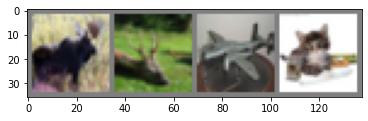

 deer  deer plane   cat


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

In [ ]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [ ]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.159
[1,  4000] loss: 1.877
[1,  6000] loss: 1.701
[1,  8000] loss: 1.598
[1, 10000] loss: 1.526
[1, 12000] loss: 1.493
[2,  2000] loss: 1.409
[2,  4000] loss: 1.396
[2,  6000] loss: 1.370
[2,  8000] loss: 1.328
[2, 10000] loss: 1.316
[2, 12000] loss: 1.292
Finished Training


In [ ]:
PATH = '/content/cifar_net.pth'
torch.save(net.state_dict(), PATH)

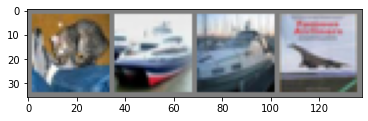

GroundTruth:    cat  ship  ship plane


In [ ]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [ ]:
net_reload = Net()
net_reload.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [ ]:
outputs = net_reload(images)

In [ ]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:    cat   car plane plane


In [ ]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net_reload(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 53 %


In [ ]:
outputs

tensor([[-2.4589, -3.3871,  0.5451,  3.6553,  1.2452,  3.0187,  1.5213,  0.5556,
         -3.3713, -3.0033],
        [-2.7857, -4.3506,  2.3302,  2.9955,  1.7457,  3.7700,  0.0628,  1.5801,
         -3.5623, -3.7252],
        [ 0.1475,  1.3105,  0.2106,  0.1320, -0.7758, -0.2380,  0.7854, -1.2581,
         -1.3411, -0.2618],
        [-1.7510, -2.0092,  0.2740,  0.3921,  2.6590,  0.6960, -0.3732,  4.4467,
         -4.4338, -1.2832]])

In [ ]:
class CIFAR10_clf(nn.Module):
  def __init__(self): 
    super(CIFAR10_clf, self).__init__() 
    self.conv1 = nn.Conv2d(3, 6, 5) 
    self.pool = nn.MaxPool2d(2, 2) 
    self.conv2 = nn.Conv2d(6, 16, 5) 
    self.fc1 = nn.Linear(16 * 5 * 5, 120) 
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)

  def forward(self, x): 
    x = self.pool(F.relu(self.conv1(x))) 
    x = self.pool(F.relu(self.conv2(x))) 
    x = x.view(-1, 16 * 5 * 5) 
    x = F.relu(self.fc1(x)) 
    x = F.relu(self.fc2(x)) 
    x = self.fc3(x) 
    return x

  def load(self, model_path): 
    self.load_state_dict(torch.load(model_path))
    self.eval()

  def predict(self, images): 
    outputs = self(images) 
    _, predicted = torch.max(outputs, 1)
    return predicted

In [ ]:
# Load the CIFAR10 classifier for inference
clf = CIFAR10_clf()
clf.load(PATH)

# Make predictions
predicted = clf.predict(images)
predicted

tensor([3, 5, 1, 7])

In [ ]:
import torch as T
device = T.device("cpu")
dummy = T.tensor([[0.5, 0.5, 0.5, 0.5]],
  dtype=T.float32).to(device)
T.onnx.export(net_reload, dummy, path, input_names=["input1"],
  output_names=["output1"])

RuntimeError: ignored